# Credit Card Fraud Detection 

**European Banking Authority (EBA)** investigates fraudulent credit card transactions. Labeling the data takes a lot of investigation time and resources. The EBA needs help from linkit e.V.'s brightest minds to speed up the initial detection process.

<img src='images/EBAcredit.png'>

EBA sends a dataset of **two** consecutive days of transaction records by european credit cardholders.

They started labeling **442 frauds** out of **284,807 transactions**. Therefore, the dataset is **highly unbalanced**. Since EBA's investigations are not completed, **not all frauds have been detected in the dataset**.

# EBA estimates, that around 11% additional frauds must be detected

Help EBA to **detect all frauds by setting up a fraud detection model**.

Due to law restrictions EBA sends anonymous data. More specifically,

- **28 principal components** obtained with **PCA** (column **V1, V2, ..., V28**)
- **Time** is the number of **seconds** elapsed since the first transaction (note that two days have 172800 seconds and the first transaction starts at midnight, 12am)
- **Amount** describes the amount of the credit card transaction in EUR
- **Class** is the dependant variable that is **1** if EBA detected a fraudulent action and **0** otherwise. Investigations are **not** complete such that a little number of frauds still can be observed with label 0

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score

In [2]:
# read the EBA dataset
dat = pd.read_csv('EBA_KreditkartenBetrug.csv')
dat.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# perform a train test split
X = dat.loc[:,dat.columns!='Class']
y = dat['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

# Random Forest Classifier

We will use a RandomForestClassifier as Baseline model

In [4]:
from sklearn.ensemble import RandomForestClassifier
NUM_ESTIMATORS = 100

In [5]:
# instantiate the classifier 
clf = RandomForestClassifier(random_state=0,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [6]:
# fit the model to the training data
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=0, verbose=False)

In [7]:
# get predictions for test data
preds = clf.predict(X_test)

In [8]:
precision = precision_score(y_test,preds)
recall = recall_score(y_test,preds)
f1 = f1_score(y_test,preds)

In [9]:
print(f"The model's precision score is {round(precision,4)}")
print(f"The model's recall score is {round(recall,4)}")
print(f"The model's F1 score is {round(f1,4)}")

The model's precision score is 0.8556
The model's recall score is 0.7064
The model's F1 score is 0.7739


## Confusion Matrix
As it can be observed in the confusion matrix, the classes are highly imbalanced. Therefore, the typical metrics for classification (such as Accuracy) are not meaningful in this scenario. For example, if 99 transactions are no frauds and 1 transaction is a fraud, a model which always predicts "no fraud" will reach 99% Accuracy, although it is not a good model for predictions. Both measures, Precision and Recall, focus on the minority class of positive frauds, which is what we want! But we need a combination of both!

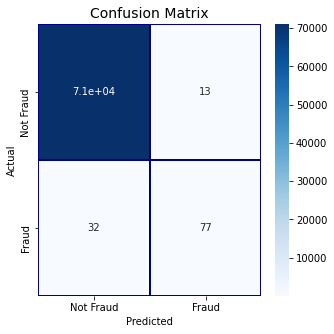

In [10]:
cm = pd.crosstab(y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## AUPRC - Area Under the Precision Recall Curve is your evaluation
A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. A model with perfect skill is depicted as a point at a coordinate of (1,1).  
A skillful model is represented by a curve that bows towards a coordinate of (1,1). A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.  
The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models.

In [11]:
precision, recall, _ = precision_recall_curve(y_test, preds)

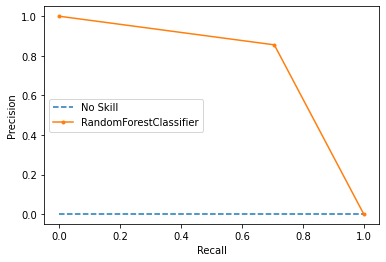

In [12]:
# calculate the no skill line as the proportion of the positive class
no_skill = y_test.mean()
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RandomForestClassifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [13]:
auprc_score = auc(recall,precision)
auprc_score

0.7812134997410562

# Submission of fraudulent transactions 

In [14]:
# combine the predicitons on the train and test
submission = pd.DataFrame(clf.predict(X), \
                          index=np.concatenate(X.index), \
                          columns=['AdvancedDetection'])

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
# Label the KNOWN fraudulent transactions
submission.loc[y[y==1].index,'AdvancedDetection'] = 1

In [ ]:
# How many frauds are there now?
submission['AdvancedDetection'].sum()

458

### Remember, EBA estimates that there are close to 11% more frauds 

In [ ]:
# What is your percentage?
print('Advanced Detection Method labels {}% more frauds'.format(\
    np.round((submission['AdvancedDetection'].sum()-y.sum())/y.sum()*100),2))

Advanced Detection Method labels 4.0% more frauds


In [ ]:
# EBA requests the whole 284,807 Class labels with hopefully
# some more insights on some other fraudulent transations
# that were not labled by the EBA

# PLEASE INSERT YOUR GROUP NAME
submission.to_csv('submission_GroupName.csv')